Latent Dirichlet Allocation (LDA) is a popular form of statistical topic modeling. In LDA, documents are represented as a mixture of topics and a topic is a bunch of words. Those topics reside within a hidden, also known as a latent layer. 

LDA looks at a document to determine a set of topics that are likely to have generated that collection of words. So, if a document uses certain words that are contained in a topic, you could say the document is about that topic.

https://blog.marketmuse.com/glossary/latent-dirichlet-allocation-definition/

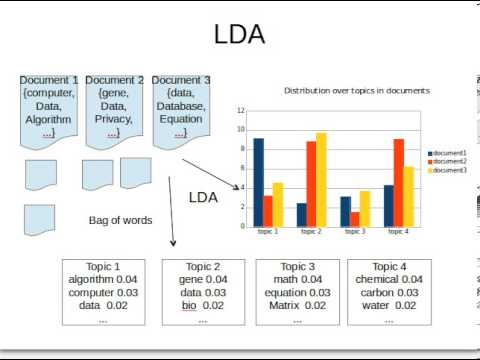

### Load dependencies and helper functions

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import math


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(math.ceil(len(model.components_)/5), 5, figsize=(20, 6*math.ceil(len(model.components_)/5)), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

def get_topic_names(model, feature_names, n_top_words):
    topic_names = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_features = [str(topic_idx+1)]+top_features
        topic_names.append("_".join(top_features))
        
        
    return topic_names

    

### We created a clean data set of articles, titles and most recent publish dates for this exercise - you can find the dataset here - 

In [171]:
data = pd.read_csv("./data/wp_posts_replace.csv")

In [172]:
data.head()

,title,content,link,date,author,type
0,5 tours nocturnos solo para valientes,5 tours nocturnos solo para valientes el turis...,https://www.plateapr.com/tours-nocturnos-en-pu...,2022-10-28T12:58:14,34,post
1,14 eventos de Halloween que no te puedes perde...,14 eventos de halloween que no te puedes perde...,https://www.plateapr.com/eventos-de-halloween-...,2022-10-28T07:05:00,13,post
2,Recorrido nocturno por Viejo San Juan y otros ...,recorrido nocturno por viejo san juan y otros ...,https://www.plateapr.com/que-hacer-este-fin-de...,2022-10-28T02:24:00,13,post
3,Distrito T-Mobile invita a participar en concu...,distrito t mobile invita a participar en concu...,https://www.plateapr.com/distrito-t-mobile-inv...,2022-10-27T17:06:47,34,post
4,10 actividades para aprovechar el fin de seman...,10 actividades para aprovechar el fin de seman...,https://www.plateapr.com/actividades-par-fin-d...,2022-10-27T04:45:00,34,post


In [173]:
data.shape

(195, 6)

In [174]:
texts = data.content

### Vectorizing Text

First, we're going to turn our original unstructured data (raw text) into a form usable by ML models.

The technique we are going to use to turn our text data into a numeric matrix is called "bag of words" - 
- 1 document = 1 row
- 1 word in our vocabulary = 1 column
- each entry = count of occurences of that word (column) in that document (row)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [243]:
places_tags = ['restaurantes',
 'ocean-park',
 'aire-libre',
 'fine-dining',
 'deportes',
 'hospedajes',
 'boutique-hotels',
 'comida-italiana',
 'cocteles',
 'hiking',
 'cuevas',
 'clases-y-workshops',
 'bakery',
 'wi-fi',
 'aventura',
 'drinks',
 'entretenimiento',
 'panaderias',
 'coffee-shops',
 'bed-amp-breakfast',
 'dinner',
 'tapas',
 'arte-y-cultura',
 'hidden-gem',
 'seafood',
 'comida-del-medio-oriente',
 'ecoturismo',
 'adventure',
 'turismo-interno',
 'mariscos',
 'familiar',
 'comida-internacional',
 'comida-americana',
 'opciones-vegetarianas-y-veganas',
 'airbnb',
 'budget-friendly',
 'food-truck',
 'reposteria',
 'brewery',
 'musica-en-vivo',
 'tours',
 'area-metro',
 'playas',
 'barras',
 'nightlife',
 'eventos',
 'parques-y-reservas',
 'shopping',
 'outdoor-dining',
 'speakeasy',
 'plaza-publica',
 'comida-vegetariana-y-vegana',
 'things-to-do',
 'comida-criolla',
 'juegos-y-diversion',
 'parking',
 'chinchorro',
 'casual-dining',
 'comida-fusion',
 'family-friendly',
 'parques',
 'museos',
 'comida-mexicana',
 'gratis',
 'pizzeria',
 'heladerias',
 'comida-asiatica',
 'mountain-bike',
 'pet-friendly',
 'rooftop',
 'postres',
 'adjuntas',
 'brunch']

places_tags = [s.split('-') for s in places_tags]



tags = []
for t in places_tags:
    if isinstance(t, list):
        tags = tags + t
    else:
        tags.append(t)
        
        
tags = ['parking', 'services', 'promotion', 'rules']

In [244]:
# Stop Words in spanish from: https://github.com/Alir3z4/stop-words/blob/master/spanish.txt
# In addition to those we added the stop words for english since we do have some spanglish on the blogs

stop_words = []

with open("./data/stop_words.txt", "r") as file:
    stop_words = file.readlines()
stop_words = [s.strip().lower() for s in stop_words]
stop_words = stop_words + tags
stop_words[len(stop_words)-10: len(stop_words)-1]

['on',
 'other',
 'under',
 'use',
 'promotions',
 '',
 'parking',
 'services',
 'promotion']

In [245]:
#define our vectorizer class


# We also tried the Tfid vectorizer but the results on the CountVectorizer seemed better.
# tf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words=stop_words, ngram_range=(1,2))
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words=stop_words, ngram_range=(1,2))


In [246]:
#fit the vectorizer to our text data and apply the transformation
tf = tf_vectorizer.fit_transform(texts)

In [247]:
# Each document is now a 1x10000 matrix as described above, and we have 10000 documents
print("Shape =",tf.shape)

Shape = (195, 10000)


In [248]:
#'tf_vectorizer.vocabulary_' this is our "vocabulary" that we inferred from the text 
#each word token we extracted and the count of that word token across the corpus
pd.DataFrame.from_dict(tf_vectorizer.vocabulary_,orient = "index").head(30)

,0
tours,9109
nocturnos,6418
valientes,9400
turismo,9253
ecológico,4008
limita,5619
horas,5167
sol,8554
diarias,3562
explorar,4526


### Set up the LDA Model

Similar to many clustering techniques, one of the main inputs to LDA is the number of topics - `n_components`.

There are other related techniques that try to infer the number of topics from the data itself such as hierarchical LDA - but the "base" model requires that input.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [263]:
n_components = 5
n_top_words = 20

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    random_state=0,
    verbose = 2 # this could take a little bit, so we specify higher verbosity for some logs
)

##### Fit our LDA model and store the topic distributions for each document in `clusters`

In [264]:
clusters = lda.fit_transform(tf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


### Now, we can visualize our topics

You can try playing around with different params and see what results you get.

The main things to tune are:
1. The number of topics - `n_components`
2. The parameters of the CountVectorizer - which basically play with how many words you would extract from the text and some logic on top of that, and therefore how many/what type of columns you have in your vectorized matrix.

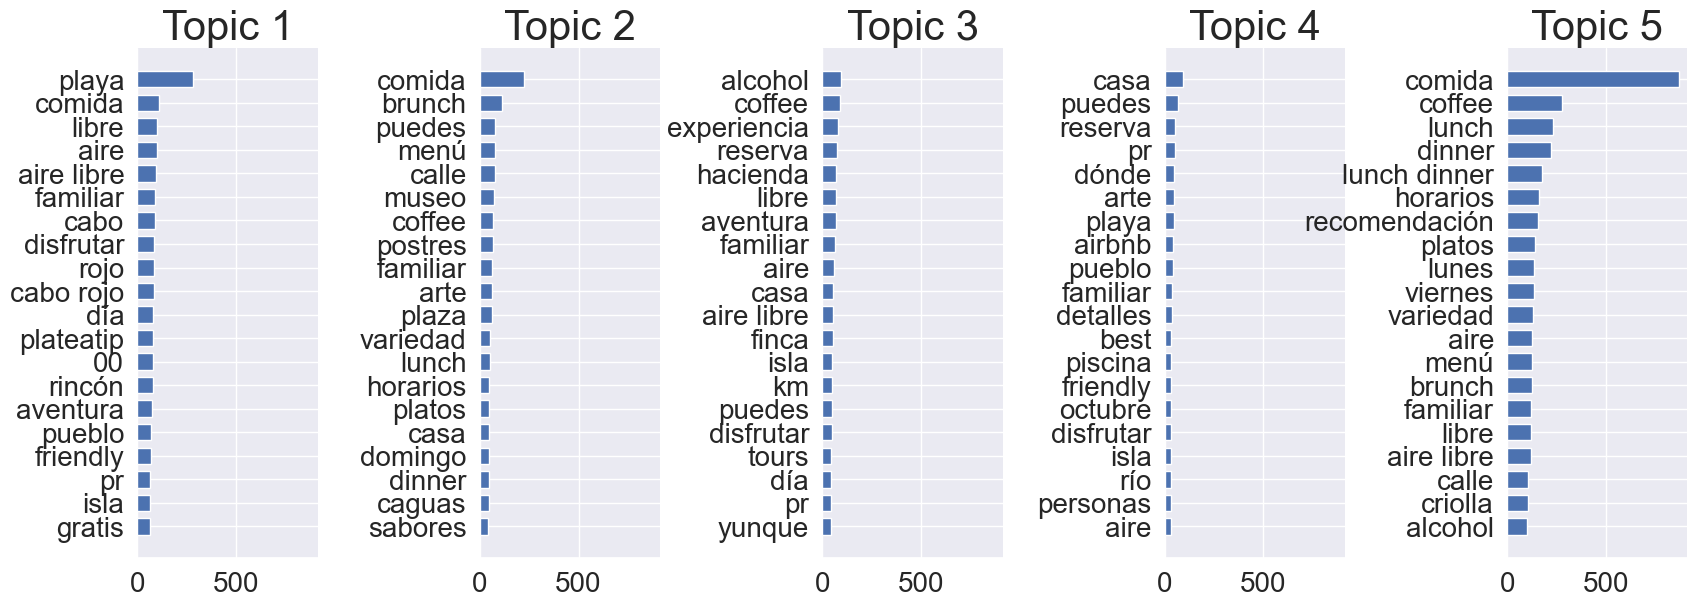

In [265]:
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "")

In [266]:
len(tf_feature_names)

10000

### We can also visualize the topic distribution of a particular article - because of how the LDA model works

The code below will take a random sample article and visualize the topic distribution of that text

In [267]:
#get topic "names" - by taking the 4 most likely word tokens in the topic
topic_names = get_topic_names(lda, feature_names=tf_feature_names, n_top_words=4)

In [268]:
sample_idx = np.random.choice(len(texts))
sample_idx

51

In [269]:
print(texts[sample_idx])

plateapr giveaway terms and services giveaway terms and services no purchase necessary to enter or win open only to legal united states residents over the age of majority void where prohibited by law conducted by:plateapr, a red ventures company1608 ave. ponce de león 4th floorsan juan, pr 00912 rules applicable to all sweepstakes and contests: these official general rules general rules govern all promotions conducted by red ventures coqui, llc plateapr on its digital channels. the term promotion means the individual sweepstakes or contests conducted by plateapr. the term digital channel means plateaprs website and social media channel pages e.g., facebook, twitter. additional rules: each promotion may also have additional terms that govern that specific promotion additional rules. the additional rules, if any, will be contained within or linked to the promotions marketing materials. if there are additional rules, the promotion will be governed by both the general rules and the additio

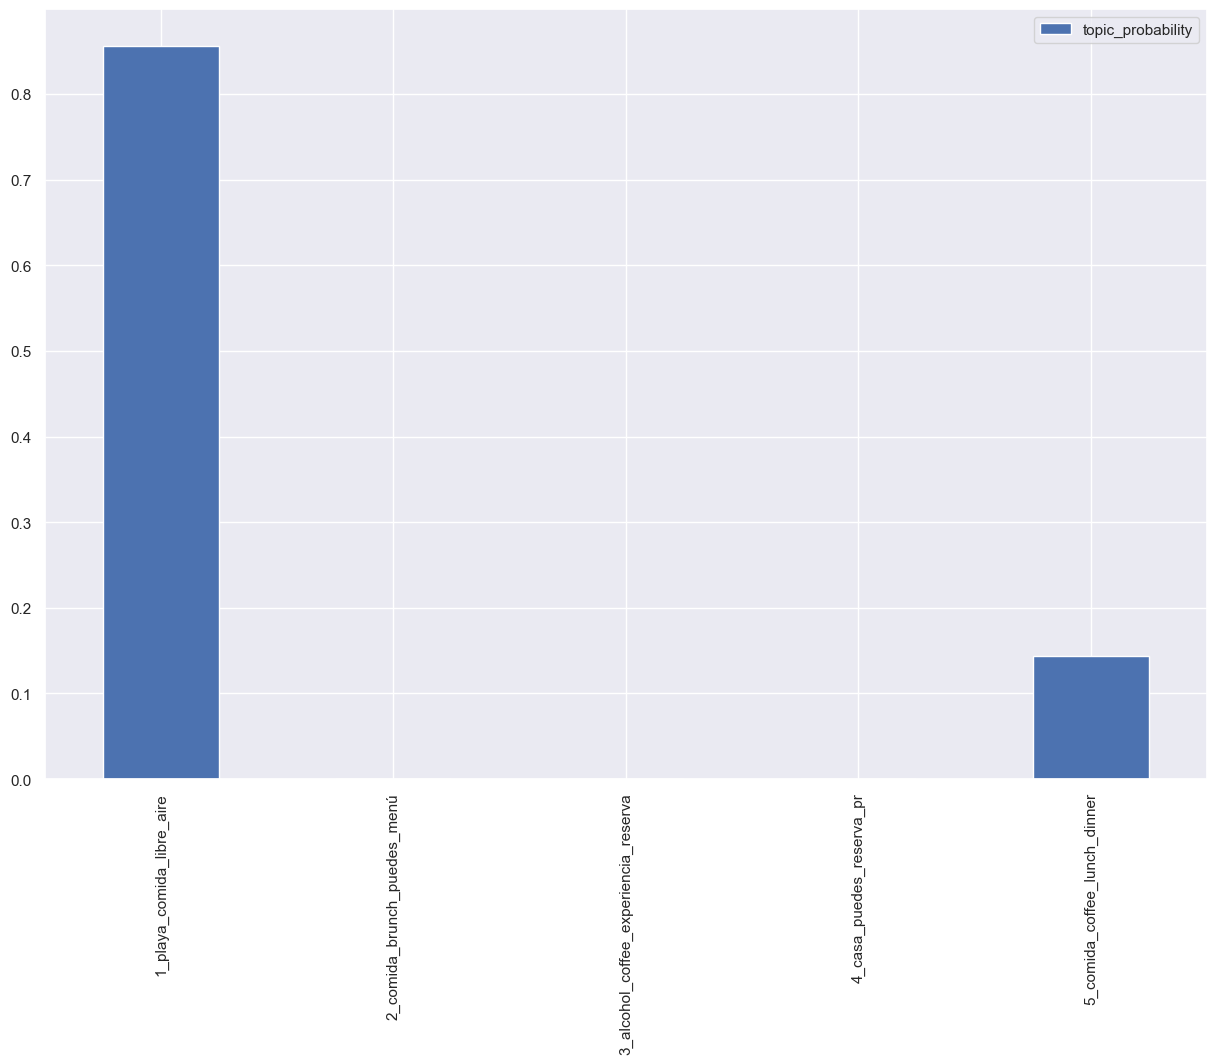

In [270]:
pd.DataFrame(index= topic_names, data= clusters[sample_idx], columns = ["topic_probability"]).plot.bar(figsize = (15,10), rot=90)
plt.show()

In [271]:
titles = data.title
topics = []
for i in range(len(data)):
    probs = pd.DataFrame(index= topic_names, data= clusters[i], columns = ["topic_probability"])
    # print(titles[i], ": ",probs[probs.topic_probability ==  max(probs.topic_probability)].index.values[0])
    topics.append(probs[probs.topic_probability ==  max(probs.topic_probability)].index.values[0]) 


In [272]:
data['topic']=topics  
data.head()


,title,content,link,date,author,type,topic
0,5 tours nocturnos solo para valientes,5 tours nocturnos solo para valientes el turis...,https://www.plateapr.com/tours-nocturnos-en-pu...,2022-10-28T12:58:14,34,post,3_alcohol_coffee_experiencia_reserva
1,14 eventos de Halloween que no te puedes perde...,14 eventos de halloween que no te puedes perde...,https://www.plateapr.com/eventos-de-halloween-...,2022-10-28T07:05:00,13,post,4_casa_puedes_reserva_pr
2,Recorrido nocturno por Viejo San Juan y otros ...,recorrido nocturno por viejo san juan y otros ...,https://www.plateapr.com/que-hacer-este-fin-de...,2022-10-28T02:24:00,13,post,4_casa_puedes_reserva_pr
3,Distrito T-Mobile invita a participar en concu...,distrito t mobile invita a participar en concu...,https://www.plateapr.com/distrito-t-mobile-inv...,2022-10-27T17:06:47,34,post,1_playa_comida_libre_aire
4,10 actividades para aprovechar el fin de seman...,10 actividades para aprovechar el fin de seman...,https://www.plateapr.com/actividades-par-fin-d...,2022-10-27T04:45:00,34,post,1_playa_comida_libre_aire


In [273]:
# Counting number of posts by topic
counts = data['topic'].value_counts().reset_index()
counts = counts.rename(columns={"topic": "count", "index":"topic"})
counts

,topic,count
0,5_comida_coffee_lunch_dinner,59
1,1_playa_comida_libre_aire,45
2,3_alcohol_coffee_experiencia_reserva,33
3,2_comida_brunch_puedes_menú,31
4,4_casa_puedes_reserva_pr,27


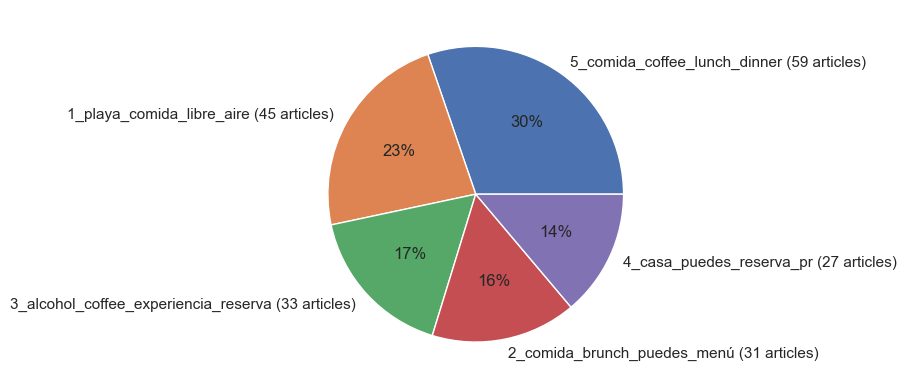

In [274]:

labels = []

for value, topic in zip(counts['count'].values, counts.topic.values):
    labels.append(f'{topic} ({value} articles)')


plt.pie(counts['count'].values, labels = labels, autopct='%.0f%%')
plt.show()

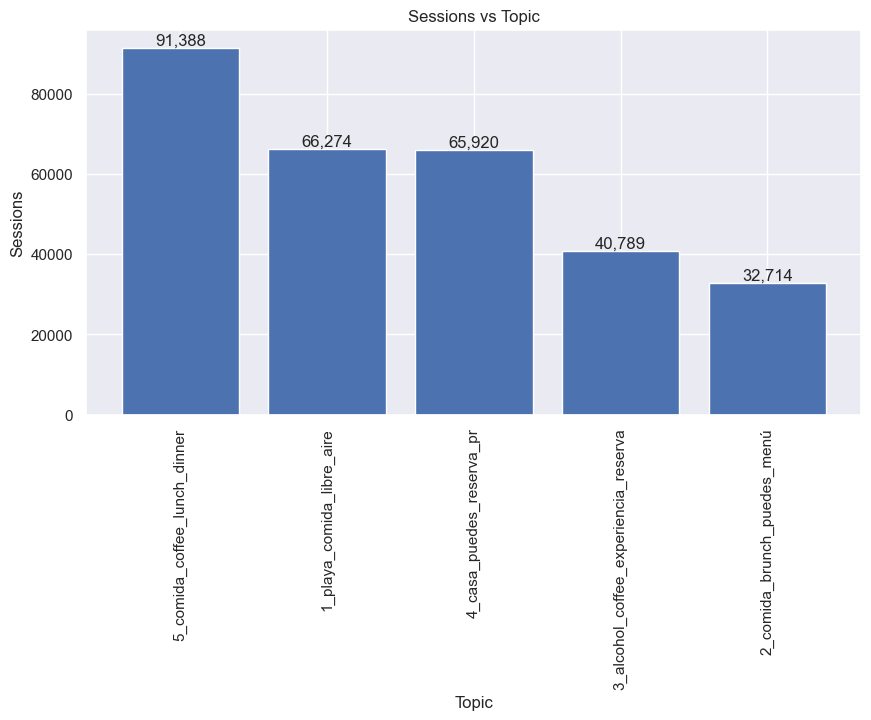

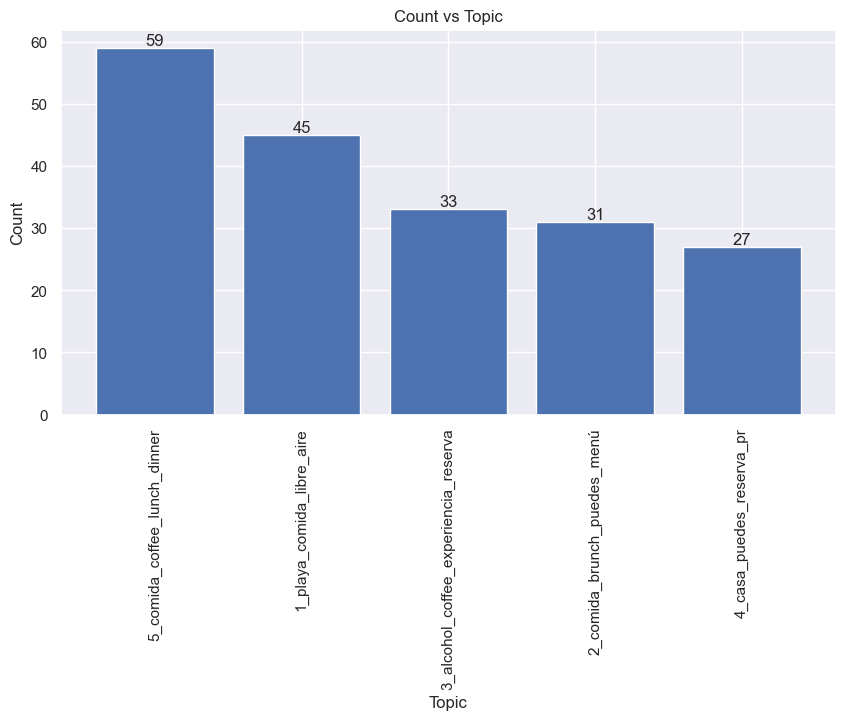

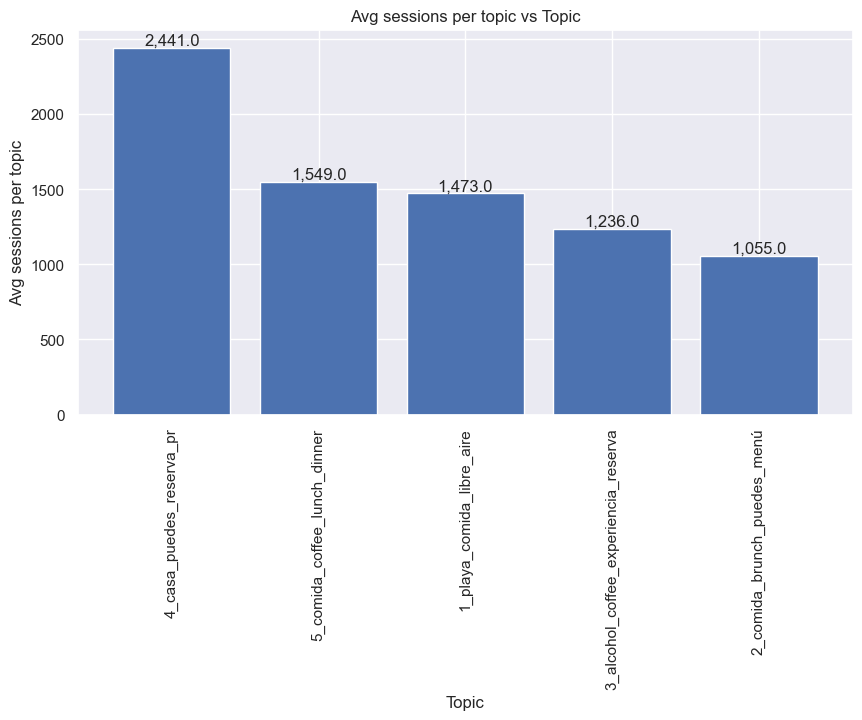

In [275]:
# Counting number of posts by topic
counts = data['topic'].value_counts().reset_index()
counts = counts.rename(columns={"topic": "count", "index":"topic"})


combined = pd.merge(data,  pd.read_csv("./data/sessions_sum.csv"), how='inner', left_on = 'link', right_on = 'url_clean')
by_topic = combined.groupby('topic').agg({'sessions': 'sum'}).reset_index()
by_topic = pd.merge(by_topic, counts, how='inner', left_on = 'topic', right_on = 'topic')

by_topic['AVG sessions per topic'] = round(by_topic['sessions']/by_topic['count'],0)


y_values = [c for c in by_topic.columns if c != 'topic']
for c in y_values:
    sorted_df = by_topic.sort_values(by=[c], ascending=False)
    figure = plt.figure('myfigureid', figsize = (10,5))
    axis = figure.add_subplot(1,1,1)
    axis.bar(sorted_df['topic'], sorted_df[c])
    
    rects = axis.patches

    # Make some labels.

    for rect, label in zip(rects, sorted_df[c]):
        height = rect.get_height()
        axis.text(
            rect.get_x() + rect.get_width() / 2, height, "{:,}".format(label), ha="center", va="bottom"
        )

    axis.set_ylabel(c.capitalize())
    axis.set_xlabel('topic'.capitalize())
    axis.set_title(f"{c.capitalize()} vs Topic")
    plt.xticks(rotation = 90)
    plt.show()

In [276]:
# See the titles on each topic to get an idea

for topic in counts['topic'].values:
    print(topic)
    for title in combined[combined.topic ==topic]['title'].values:
        print(f'\t\t{title}')
    print('\n')

5_comida_coffee_lunch_dinner
		Ruta por Lares: Qué hacer y dónde comer
		Restaurantes en Aguadilla para arrasar en tu primera cita
		8 terrazas únicas donde puedes tomarte un buen café
		3 restaurantes que dan cátedra de recuperación tras Fiona
		Restaurantes y coffee shops locales abiertos tras el paso de Fiona por la isla
		Coffee shops para coffee lovers en San Juan
		8 lugares con buenos especiales de almuerzo por $12 o menos
		Ocho barras con vista al mar para visitar en Puerto Rico
		Kioskos en Piñones para matar los munchies después de la playa
		6 spots con cervezas bien frías para ver el juego
		7 pizzerías cerca de San Juan para los foodies más exigentes
		Nuevos restaurantes en la zona metro que hay que probar sí o sí en agosto
		Restaurantes románticos para tu date night en San Juan
		Qué hacer y comer con $30 en la Calle Loíza
		7 barras para visitar después de un día largo de trabajo 
		7 restaurantes fuera del área metro durante Puerto Rico Restaurant Week
		7 restaurant